# Outstanding ballots in CA

In [1]:
import pandas as pd
import geopandas as gpd
from altair_saver import save
import altair as alt
import altair_latimes as lat
alt.themes.register("latimes", lat.theme)
alt.themes.enable("latimes")
pd.options.display.max_columns = 50
pd.options.display.max_rows = 34000
pd.set_option('display.max_colwidth', None)

### What day is it? 

In [2]:
now = pd.Timestamp('today')

### Define our metro area

In [3]:
socal = [ 'Riverside','Los Angeles','Ventura','San Bernardino','Orange' ]

---

In [4]:
### VBM vs. vote centers in LA County

In [5]:
la_url = 'https://results.lavote.net/text-results/4193'

In [6]:
la_tables = pd.read_html(la_url)

In [7]:
la_vote = la_tables[1]

In [8]:
la_vote = la_vote.rename(columns={ 'Statistic':'statistic', 'Count':'count', 'Percent':'pct' })

In [9]:
la_vote['pct'] = la_vote['pct'].str.replace('%','').astype(float)

In [10]:
la_vote['count'] = la_vote['count'].astype(int)

In [11]:
la_vote['statistic'] = la_vote['statistic'].str.replace(' Ballots','')

In [12]:
la_vote.to_csv('output/la_county_ballot_breakdown.csv', index=False)

---

### Get latest results from Secretary of State

In [13]:
url = 'https://electionresults.sos.ca.gov/returns/status'

In [14]:
tables = pd.read_html(url, parse_dates=True)

### Clean up results

In [15]:
results_src = tables[0].drop([58,59], axis=0)

In [16]:
results = results_src.rename(columns={'County Name':'county', 'TotalPrecincts':'total_pcts','PrecinctsPartiallyReporting *':'precincts_partially','% PartiallyReporting **':'reporting_pct',\
                            'RegisteredVoters':'voters', 'Ballots Cast':'ballots_cast','% Turnout ***':'turnout_pct','FirstReportDate-Time':'first_report','Last Report Date-Time':'last_report','ReportType****':'report_type'})

In [17]:
results.reporting_pct = results.reporting_pct.str.replace('%', '', regex=False)

In [18]:
results.turnout_pct = results.turnout_pct.str.replace('%', '', regex=False)

In [19]:
results[['total_pcts', 'precincts_partially', 'voters', 'ballots_cast', 'turnout_pct']] = \
results[['total_pcts', 'precincts_partially', 'voters', 'ballots_cast', 'turnout_pct']].astype(int)

### Results in our counties

In [20]:
socal_results = results[results['county'].isin(socal)]

In [21]:
socal_results.head()

county  total_pcts  precincts_partially reporting_pct   voters  \
18     Los Angeles        3383                 3383         100.0  5813333   
29          Orange        1795                 1795         100.0  1772700   
32       Riverside         864                  864         100.0  1241552   
35  San Bernardino        2327                 2327         100.0  1102687   
55         Ventura         695                  695         100.0   500442   

    ballots_cast  turnout_pct     first_report      last_report report_type  
18       4211649           72   Nov 38:21 p.m.  Nov 104:02 p.m.           U  
29       1527434           86   Nov 38:33 p.m.  Nov 115:09 p.m.           U  
32        730679           58   Nov 38:47 p.m.  Nov 116:11 p.m.           U  
35        684692           62  Nov 310:07 p.m.  Nov 104:06 p.m.           U  
55        424161           84   Nov 38:31 p.m.  Nov 104:09 p.m.           U

### Turnout (so far) in SoCal

In [22]:
round(socal_results.ballots_cast.sum() / socal_results.voters.sum()*100,2)

72.66

---

### Download latest outstanding ballots report from Secretary of State

In [23]:
!wget 'https://elections.cdn.sos.ca.gov/statewide-elections/2020-general/unprocessed-ballots-report.pdf' -F -O input/unprocessed-ballots-report.pdf

--2020-11-12 08:49:13--  https://elections.cdn.sos.ca.gov/statewide-elections/2020-general/unprocessed-ballots-report.pdf
Resolving elections.cdn.sos.ca.gov (elections.cdn.sos.ca.gov)... 204.147.113.115
Connecting to elections.cdn.sos.ca.gov (elections.cdn.sos.ca.gov)|204.147.113.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117519 (115K) [application/pdf]
Saving to: ‘input/unprocessed-ballots-report.pdf’

input/unprocessed-b 100%[===================>] 114.76K  --.-KB/s    in 0.09s   

2020-11-12 08:49:13 (1.22 MB/s) - ‘input/unprocessed-ballots-report.pdf’ saved [117519/117519]



### Export text from PDF and read into dataframe

In [24]:
!PDFtoText -layout 'input/unprocessed-ballots-report.pdf'

In [25]:
src = pd.read_fwf('input/unprocessed-ballots-report.txt', skiprows=6, skipfooter=7, infer_nrows=60, header=None).dropna(axis=1)

### When was this updated? 

In [26]:
updated_date = pd.read_fwf('input/unprocessed-ballots-report.txt', skiprows=69, skipfooter=1, header=None, infer_nrows=3)

In [27]:
updated = updated_date.drop([0,1,4], axis=1).rename(columns={2:'date', 3:'time'})

In [28]:
updated

date  time
0  11/10/20  6:00

---

### Clean up headers, parse columns

In [29]:
outstanding = src.rename(columns={0:'county', 1:'mail_out',4:'provisional_out',7:'cond_prov_out',8:'other_out',11:'total_out', 13:'updated'})

In [30]:
outstanding.county = outstanding.county.str.replace('**', '', regex=False)

In [31]:
str_cols = ['mail_out','provisional_out','cond_prov_out','other_out','total_out']
outstanding[str_cols] = outstanding[str_cols].replace(',', '', regex=True)

In [32]:
outstanding[str_cols] = outstanding[str_cols].astype(int)

In [33]:
outstanding.updated = pd.to_datetime(outstanding.updated)

### Outstanding in SoCal

In [34]:
outstanding[outstanding['county'].isin(socal)]

county  mail_out  provisional_out  cond_prov_out  other_out  \
18     Los Angeles     69485             1550          65680       6000   
29          Orange      4731                0          21140       1826   
32       Riverside    215000                0          25000          0   
35  San Bernardino    156000            19000              0       1300   
55         Ventura       300              350           1000       3773   

    total_out             updated  
18     142715 2020-11-10 16:02:00  
29      27697 2020-11-09 17:30:00  
32     240000 2020-11-09 17:44:00  
35     176300 2020-11-10 16:06:00  
55       5423 2020-11-10 16:09:00

### Export to csv

In [35]:
outstanding.to_csv('output/outstanding/' + f'counties_outstanding_ballots_{now:%m%d%Y_%H:%M}.csv', index=False)
results.to_csv('output/results/' + f'results_{now:%m%d%Y_%H:%M}.csv', index=False)

### Merge outstanding ballots with current results

In [36]:
ballots = results.merge(outstanding, on='county')

In [37]:
len(ballots)

58

In [38]:
ballots.head()

county  total_pcts  precincts_partially reporting_pct  voters  \
0    Alameda         521                  521         100.0  966809   
1     Alpine           5                    5         100.0     869   
2     Amador          30                   30         100.0   25605   
3      Butte         157                  157         100.0  124793   
4  Calaveras          29                   29         100.0   31364   

   ballots_cast  turnout_pct    first_report      last_report report_type  \
0        765025           79  Nov 38:21 p.m.  Nov 104:56 p.m.           U   
1           739           85  Nov 39:14 p.m.  Nov 311:11 p.m.          SF   
2         22601           88  Nov 38:17 p.m.  Nov 101:29 p.m.           U   
3        101342           81  Nov 38:42 p.m.   Nov 94:49 p.m.           U   
4         27070           86  Nov 39:17 p.m.   Nov 93:04 p.m.           U   

   mail_out  provisional_out  cond_prov_out  other_out  total_out  \
0      9353                0            100          0       9453   
1         8                0              0          2         10   
2         0                0              0         79         79   
3        40              400           1640          0       2080   
4        59               23             32        375        489   

              updated  
0 2020-11-10 16:56:00  
1 2020-11-03 23:11:00  
2 2020-11-10 13:29:00  
3 2020-11-09 16:49:00  
4 2020-11-09 15:04:00

### Votes left to count as a percentage of all registered voters

In [39]:
ballots['out_rate'] = round((ballots.mail_out / ballots.voters)*100,2)

In [40]:
ballots_slim = ballots[[ 'county', 'voters', 'ballots_cast', 'turnout_pct', 'mail_out', 'total_out', 'out_rate' ]]

In [41]:
ballots_slim.head()

county  voters  ballots_cast  turnout_pct  mail_out  total_out  out_rate
0    Alameda  966809        765025           79      9353       9453      0.97
1     Alpine     869           739           85         8         10      0.92
2     Amador   25605         22601           88         0         79      0.00
3      Butte  124793        101342           81        40       2080      0.03
4  Calaveras   31364         27070           86        59        489      0.19

In [42]:
ballots_slim[ballots_slim['county'].isin(socal)]

county   voters  ballots_cast  turnout_pct  mail_out  total_out  \
18     Los Angeles  5813333       4211649           72     69485     142715   
29          Orange  1772700       1527434           86      4731      27697   
32       Riverside  1241552        730679           58    215000     240000   
35  San Bernardino  1102687        684692           62    156000     176300   
55         Ventura   500442        424161           84       300       5423   

    out_rate  
18      1.20  
29      0.27  
32     17.32  
35     14.15  
55      0.06

In [43]:
ballots_slim.mail_out.sum()

1126592

In [44]:
ballots_slim.total_out.sum()

1484033

---

## Geography

In [45]:
counties_geo = gpd.read_file('http://s3-us-west-2.amazonaws.com/boundaries.latimes.com/archive/1.0/boundary-set/counties-2012.geojson')

### Merge outstanding ballots and current results to geodataframe

In [46]:
ballots_geo = counties_geo.merge(ballots_slim, left_on='name', right_on='county')

<AxesSubplot:>

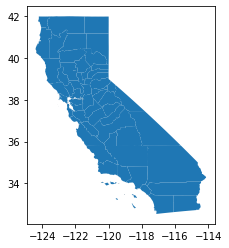

In [47]:
ballots_geo.plot()

### Export

In [48]:
ballots_geo.to_file('output/ballots_geo.geojson', driver='GeoJSON')